## Task 2
We throw independently balls into n bins until all bins are non-empty. Let C be the
number of thrown balls.

In [54]:
import timeit
import numpy as np
import sympy as sp
import itertools
import numba
from time import time
from matplotlib import pyplot as plt

Let's try 4 different approaches to execute the function and one with using numba

In [2]:
def simulate_bins_and_balls_1(num_of_bins):
    upper_bound = num_of_bins + 1
    histogram = {bin_: 0 for bin_ in range(1, upper_bound)}
    while 0 in histogram.values():
        histogram[np.random.randint(1, upper_bound)] += 1
    return np.array(list(histogram.values())).sum()

In [3]:
def simulate_bins_and_balls_2(num_of_bins):
    occurrences = set()
    upper_bound = num_of_bins + 1
    for counter in itertools.count(start=1, step=1):
        occurrences.add(np.random.randint(1, upper_bound))
        if len(occurrences) == num_of_bins:
            return counter

In [4]:
def simulate_bins_and_balls_3(num_of_bins):
    occurrences = set()
    counter = 0
    upper_bound = num_of_bins + 1
    while len(occurrences) < num_of_bins:
        occurrences.add(np.random.randint(1, upper_bound))
        counter += 1
    return counter

In [5]:
@numba.njit()
def simulate_bins_and_balls_4(num_of_bins):
    occurrences = set()
    counter = 0
    upper_bound = num_of_bins + 1
    while len(occurrences) < num_of_bins:
        occurrences.add(np.random.randint(1, upper_bound))
        counter += 1
    return counter

In [6]:
number_of_bins = 10000

Let's see example experiment results

In [7]:
print(f'Function 1: {simulate_bins_and_balls_1(number_of_bins)}')
print(f'Function 2: {simulate_bins_and_balls_2(number_of_bins)}')
print(f'Function 3: {simulate_bins_and_balls_3(number_of_bins)}')
print(f'Function 4: {simulate_bins_and_balls_4(number_of_bins)}')

Function 1: 96283
Function 2: 101536
Function 3: 120134
Function 4: 99466


Let's compare the performance

In [8]:
%%timeit
simulate_bins_and_balls_1(number_of_bins)

The slowest run took 9.96 times longer than the fastest. This could mean that an intermediate result is being cached.
1.47 s ± 1.42 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%%timeit
simulate_bins_and_balls_2(number_of_bins)

277 ms ± 31.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit
simulate_bins_and_balls_3(number_of_bins)

296 ms ± 25.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
simulate_bins_and_balls_4(number_of_bins)

2.32 ms ± 48.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's repeat the experiment many times and compare three different combinations

In [12]:
def repeat_experiments_1(num_of_bins, num_of_trials):
    return np.fromiter((simulate_bins_and_balls_2(num_of_bins) for _ in range(num_of_trials)), int)

In [13]:
@numba.njit()
def repeat_experiments_2(num_of_bins, num_of_trials):
    results = np.zeros(num_of_trials)
    for i in range(num_of_trials):
        results[i] = simulate_bins_and_balls_4(num_of_bins)
    return results 

In [14]:
@numba.njit(parallel=True)
def repeat_experiments_3(num_of_bins, num_of_trials):
    results = np.zeros(num_of_trials)
    for i in numba.prange(num_of_trials):
        results[i] = simulate_bins_and_balls_4(num_of_bins)
    return results 

Let's see example experiment results

In [15]:
number_of_bins = 200
number_of_trials = 20

In [16]:
print(f'Experiment 1: {repeat_experiments_1(number_of_bins, number_of_trials)}')
print(f'Experiment 2: {repeat_experiments_2(number_of_bins, number_of_trials)}')
print(f'Experiment 3: {repeat_experiments_3(number_of_bins, number_of_trials)}')

Experiment 1: [1228  894 1087 1154 1005 1371  954 1835 1366 1185  884 1111 1107 1204
 1063 1039 1361 1190 1338 1089]
Experiment 2: [1012. 1125. 1159. 1175. 1109.  941.  910. 1665. 1268. 1252. 1067. 1510.
  823. 1496. 1168.  993. 1044. 1198. 1153. 1230.]
Experiment 3: [1250. 1267. 1033. 1135. 1383. 1486.  824. 1225.  977.  742. 1378. 1044.
 1155. 1051. 1431. 1303. 1031. 1172. 1098.  934.]


Now let's check the performance of all solutions

In [17]:
number_of_trials = 5000

In [18]:
%%timeit
repeat_experiments_1(number_of_bins, number_of_trials)

16.1 s ± 194 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
repeat_experiments_2(number_of_bins, number_of_trials)

113 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
%%timeit
repeat_experiments_3(number_of_bins, number_of_trials)

17.3 ms ± 845 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's check how much time it takes to run 1000 bins 1000000 times

In [21]:
%%timeit
repeat_experiments_3(1000, 1000000)

16.4 s ± 97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
parameters = [10, 100, 1000]
histograms = []
times = []
number_of_trials = 1000000

for n in parameters:
    time1 = time()
    histograms.append(repeat_experiments_3(n, number_of_trials))
    time2 = time()
    times.append(round(time2 - time1, 5))
print(*times)

0.129 1.322 16.49


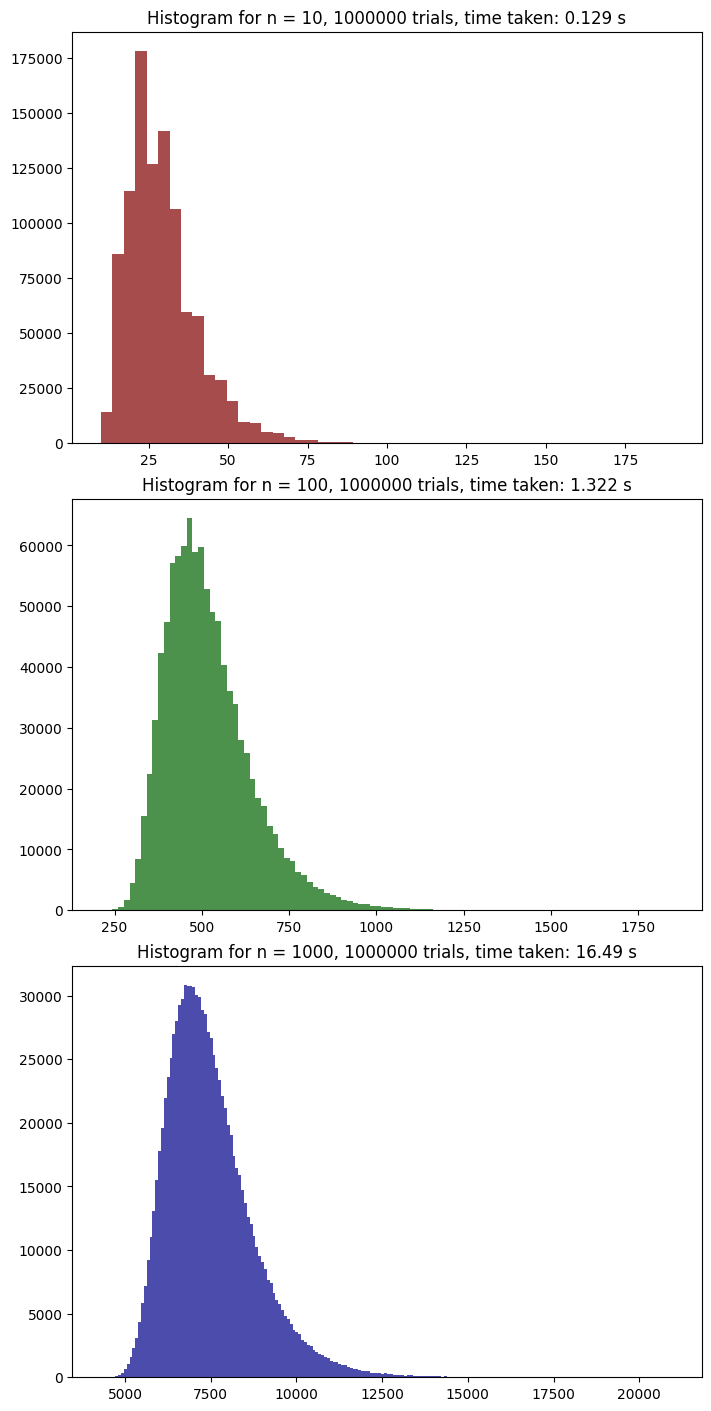

In [49]:
figure, axes = plt.subplots(3, 1, layout='constrained', figsize=(7,14))

bins = [50, 100, 200]
colors = ['maroon', 'darkgreen', 'darkblue']
for index, (result, num_bins, color, time_, bin_) in enumerate(zip(histograms, parameters, colors, times, bins)):
    axes[index].hist(result, bins=bin_, color=color, alpha=0.7)
    title = f'Histogram for n = {num_bins}, {number_of_trials} trials, time taken: {time_} s'
    axes[index].set(title=title)

<ul><li> n ∈ [10, 50000] find an approximation of E(C). Compare this with the theoretical results presented during the lecture.</li></ul>

In [24]:
bin_range = np.arange(10, 100, 10)

In [44]:
def expected_value_1(n_range, num_of_trials):
    expected_value = np.zeros(len(n_range))
    for index, n in enumerate(n_range):
        expected_value[index] = repeat_experiments_3(n, num_of_trials).mean()
    return expected_value

In [45]:
@numba.njit()
def expected_value_2(n_range, num_of_trials):
    expected_value = np.zeros(len(n_range))
    for index, n in enumerate(n_range):
        expected_value[index] = repeat_experiments_3(n, num_of_trials).mean()
    return expected_value

In [46]:
@numba.njit(parallel=True)
def expected_value_3(n_range, num_of_trials):
    expected_value = np.zeros(len(n_range))
    for i in numba.prange(len(n_range)):
        expected_value[i] = repeat_experiments_3(n_range[i], num_of_trials).mean()
    return expected_value

Let's test if it works correctly

In [28]:
print(f'Expected value 1: {expected_value_1(bin_range, 10000)}')
print(f'Expected value 2: {expected_value_2(bin_range, 10000)}')
print(f'Expected value 3: {expected_value_3(bin_range, 10000)}')

Expected value 1: (array([10, 20, 30, 40, 50, 60, 70, 80, 90]), array([ 29.1069,  71.9554, 119.6703, 170.9115, 225.3394, 280.2363,
       338.0658, 398.0777, 457.8858]))
Expected value 2: (array([10, 20, 30, 40, 50, 60, 70, 80, 90]), array([ 29.3569,  72.0866, 119.4921, 170.881 , 224.649 , 279.1173,
       337.8522, 396.1675, 458.2054]))
Expected value 3: (array([10, 20, 30, 40, 50, 60, 70, 80, 90]), array([ 29.2222,  72.2937, 119.7945, 171.7512, 225.4516, 279.8049,
       337.4279, 396.8809, 459.2596]))


let's check performance

In [29]:
bin_range = np.arange(10, 5000, 100)

In [30]:
%%timeit
expected_value_1(bin_range, 1000)

3.39 s ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%%timeit
expected_value_2(bin_range, 1000)

3.25 s ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%%timeit
expected_value_3(bin_range, 1000)

4.23 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can see that repeating parallel again is not as efficient, as it was done twice earlier. We can stick to option 1.

In [47]:
bin_range = np.arange(10, 5000, 20)
trials = 100

In [52]:
time1 = time()
expected_value_range = expected_value_1(bin_range, trials)
time2 = time()
time_passed = round(time2 - time1, 3)

In [55]:
x = sp.symbols('N', integer=True)
f = x * sp.ln(x) + 0.577 * x
f_x = sp.lambdify(x, f, 'numpy')(bin_range)

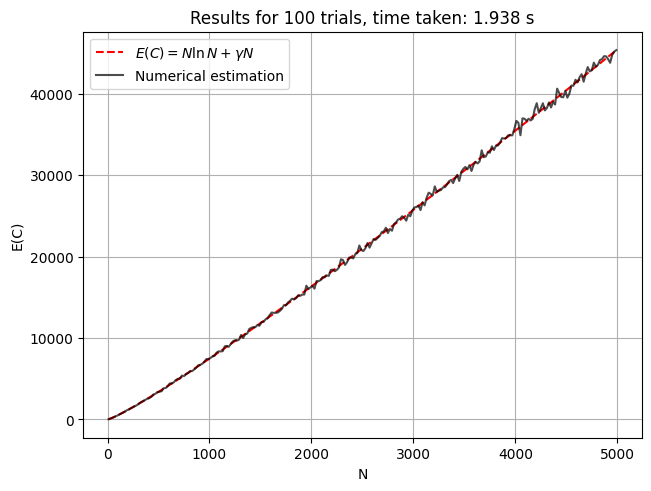

In [60]:
figure2, axes2 = plt.subplots(1, 1, layout='constrained')
axes2.set(xlabel='N', ylabel='E(C)')
axes2.set_title(f'Results for {trials} trials, time taken: {time_passed} s')
axes2.grid()
axes2.plot(bin_range, f_x, color='red', linestyle='--', label='$E(C)=N \ln{N} + \gamma N$')
axes2.plot(bin_range, expected_value_range, color='black', label='Numerical estimation', alpha=0.7)
axes2.legend()